In [22]:
import torch
import timm
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch
import torch.optim as optim
import os
import random
import shutil
from torchvision import datasets
from csvlogger import CSVLogger
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [23]:
avail_pretrained_models = timm.list_models(pretrained=True)
print(avail_pretrained_models)

['bat_resnext26ts.ch_in1k', 'beit_base_patch16_224.in22k_ft_in22k', 'beit_base_patch16_224.in22k_ft_in22k_in1k', 'beit_base_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_224.in22k_ft_in22k', 'beit_large_patch16_224.in22k_ft_in22k_in1k', 'beit_large_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_512.in22k_ft_in22k_in1k', 'beitv2_base_patch16_224.in1k_ft_in1k', 'beitv2_base_patch16_224.in1k_ft_in22k', 'beitv2_base_patch16_224.in1k_ft_in22k_in1k', 'beitv2_large_patch16_224.in1k_ft_in1k', 'beitv2_large_patch16_224.in1k_ft_in22k', 'beitv2_large_patch16_224.in1k_ft_in22k_in1k', 'botnet26t_256.c1_in1k', 'caformer_b36.sail_in1k', 'caformer_b36.sail_in1k_384', 'caformer_b36.sail_in22k', 'caformer_b36.sail_in22k_ft_in1k', 'caformer_b36.sail_in22k_ft_in1k_384', 'caformer_m36.sail_in1k', 'caformer_m36.sail_in1k_384', 'caformer_m36.sail_in22k', 'caformer_m36.sail_in22k_ft_in1k', 'caformer_m36.sail_in22k_ft_in1k_384', 'caformer_s18.sail_in1k', 'caformer_s18.sail_in1k_384', 'caformer_s

In [24]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
 
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
       
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 11.8
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce RTX 3060 Laptop GPU


In [25]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Device: {device}")

Device: cuda


In [26]:
print(os.listdir('Binary_ttv\\src')) # Preliminary Image Processing\Alzheimer_s Dataset_binary\src
print(os.listdir('Binary_ttv\\train'))
print(os.listdir('Binary_ttv\\test'))
print(os.listdir('Binary_ttv\\val'))

['Demented', 'NonDemented']
['Demented', 'NonDemented']
['Demented', 'NonDemented']
['Demented', 'NonDemented']


In [27]:
# Define transformations for image preprocessing
transform = transforms.Compose([
    transforms.Resize((176, 208)),  # Resize images to a common size (adjust as needed)
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # Normalize using ImageNet stats
])

# Load training and testing datasets
train_dataset = ImageFolder(root='Binary_ttv\\train', transform=transform)
test_dataset = ImageFolder(root='Binary_ttv\\test', transform=transform)
val_dataset = ImageFolder(root='Binary_ttv\\val', transform=transform)

batch_size = 26  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

print(len(train_loader))
print(len(test_loader))
print(len(val_loader))
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

3620
499
499
94110
12965
12967


In [28]:
learning_rate = 0.0001
epochs = 100
patience = 5

Resnet50

In [8]:
model = timm.create_model('resnet50', pretrained=True, num_classes=2, drop_rate=0.2).to(device)

losslogger = CSVLogger('resnet50_loss.csv', fieldnames=["datetime", "batch", "epoch", "train_loss", "val_loss", "val_accuracy"])
acclogger = CSVLogger('resnet50_acc.csv', fieldnames=["datetime", "average_accuracy"])
loss_value = torch.nn.CrossEntropyLoss()

model_opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Training loop
num_epochs = epochs  
early_stopping = False  
best_loss = float('inf') 

print(f"Device: {device}")

print(f"Start time: {datetime.datetime.now()}")


for epoch in range(num_epochs):
    model.train()  
    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        model_opt.zero_grad()
        outputs = model(inputs)
        loss = loss_value(outputs, labels)
        loss.backward()
        model_opt.step()
    
    # Validation
    model.eval()  
    total = 0
    correct = 0
    val_loss = 0.0
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss += loss_value(val_outputs, val_labels).item()
        _, predicted = torch.max(val_outputs.data, 1)
        total += val_labels.size(0)
        correct += (predicted == val_labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    losslog_data = {"datetime": datetime.datetime.now(), "batch": batch_size, "epoch": epoch+1, "train_loss": loss.item(), "val_loss": val_loss, "val_accuracy": val_accuracy}
    losslogger.log(losslog_data)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0  
    else:
        patience_counter += 1  
        
        # If validation loss hasn't improved for 'patience' epochs, stop early
        if patience_counter >= patience:
            print("Early stopping triggered")
            early_stopping = True
            break
    
    if early_stopping:
        break
    
    print(f"Completed epoch {epoch + 1} with loss {loss.item()}, validation loss {val_loss}")

# -----------------------------------------

correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
acclog_data = {"datetime": datetime.datetime.now(), "average_accuracy": accuracy}
acclogger.log(acclog_data)
print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# -----------------------------------------



Device: cuda
Start time: 2023-11-02 00:15:56.485379
Completed epoch 1 with loss 0.23482131958007812, validation loss 0.4385042772264423
Completed epoch 2 with loss 0.277627557516098, validation loss 0.39016750669909384
Completed epoch 3 with loss 0.3319411873817444, validation loss 0.36461888202176784
Completed epoch 4 with loss 0.335933119058609, validation loss 0.34535748226370266
Completed epoch 5 with loss 0.15889272093772888, validation loss 0.33056628205748145
Completed epoch 6 with loss 0.2141173928976059, validation loss 0.31447747797576453
Completed epoch 7 with loss 0.31498539447784424, validation loss 0.3015002883272712
Completed epoch 8 with loss 0.4439947009086609, validation loss 0.2892100368309132
Completed epoch 9 with loss 0.28621622920036316, validation loss 0.2779121011232431
Completed epoch 10 with loss 0.12704896926879883, validation loss 0.2712287392153709
Completed epoch 11 with loss 0.4339415431022644, validation loss 0.2542103853114957
Completed epoch 12 with l

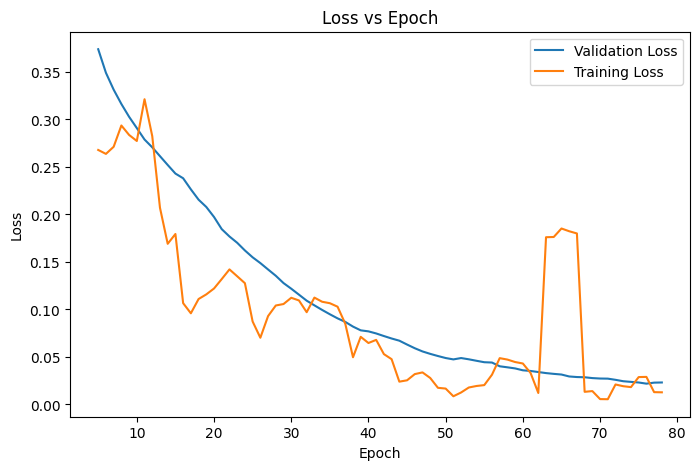

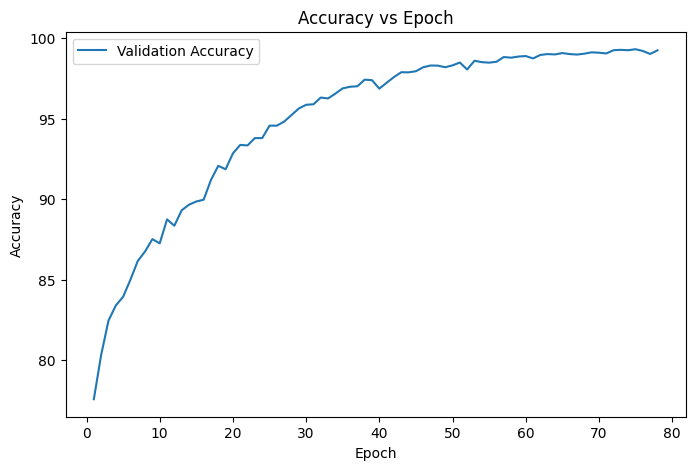

In [9]:
lossdf = pd.read_csv("resnet50_loss.csv", engine="pyarrow")
rolling_mean = lossdf["val_loss"].rolling(window=5).mean()
rolling_mean2 = lossdf["train_loss"].rolling(window=5).mean()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], rolling_mean, label="Validation Loss")
plt.plot(lossdf["epoch"], rolling_mean2, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], lossdf["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.show()

In [ ]:
lossdf = pd.read_csv("vgg16_loss.csv", engine="pyarrow")
rolling_mean = lossdf["val_loss"].rolling(window=5).mean()
rolling_mean2 = lossdf["train_loss"].rolling(window=5).mean()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], rolling_mean, label="Validation Loss")
plt.plot(lossdf["epoch"], rolling_mean2, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], lossdf["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.show()

Mobilenet

In [19]:
model = timm.create_model('mobilenetv3_large_100', pretrained=True, num_classes=2, drop_rate=0.2).to(device)

losslogger = CSVLogger('mobilenetv3_large_loss.csv', fieldnames=["datetime", "batch", "epoch", "train_loss", "val_loss", "val_accuracy"])
acclogger = CSVLogger('mobilenetv3_large_acc.csv', fieldnames=["datetime", "average_accuracy"])
loss_value = torch.nn.CrossEntropyLoss()

model_opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Training loop
num_epochs = epochs  
early_stopping = False  
best_loss = float('inf') 

print(f"Device: {device}")

print(f"Start time: {datetime.datetime.now()}")


for epoch in range(num_epochs):
    model.train()  
    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        model_opt.zero_grad()
        outputs = model(inputs)
        loss = loss_value(outputs, labels)
        loss.backward()
        model_opt.step()
    
    # Validation
    model.eval()  
    total = 0
    correct = 0
    val_loss = 0.0
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss += loss_value(val_outputs, val_labels).item()
        _, predicted = torch.max(val_outputs.data, 1)
        total += val_labels.size(0)
        correct += (predicted == val_labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    losslog_data = {"datetime": datetime.datetime.now(), "batch": batch_size, "epoch": epoch+1, "train_loss": loss.item(), "val_loss": val_loss, "val_accuracy": val_accuracy}
    losslogger.log(losslog_data)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0  
    else:
        patience_counter += 1  
        
        # If validation loss hasn't improved for 'patience' epochs, stop early
        if patience_counter >= patience:
            print("Early stopping triggered")
            early_stopping = True
            break
    
    if early_stopping:
        break
    
    print(f"Completed epoch {epoch + 1} with loss {loss.item()}, validation loss {val_loss}")

# -----------------------------------------

correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
acclog_data = {"datetime": datetime.datetime.now(), "average_accuracy": accuracy}
acclogger.log(acclog_data)
print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# Save the model
torch.save(model.state_dict(), 'mobilenetv3_large.pth')


Device: cuda
Start time: 2023-11-02 14:25:26.683058
Completed epoch 1 with loss 0.04055780544877052, validation loss 0.1952510912747868
Completed epoch 2 with loss 0.010466552339494228, validation loss 0.10387345766676566
Completed epoch 3 with loss 0.01143277995288372, validation loss 0.0576947878786769
Completed epoch 4 with loss 0.08788588643074036, validation loss 0.04462453438539581
Completed epoch 5 with loss 0.013846207410097122, validation loss 0.027133099366916196
Completed epoch 6 with loss 0.01576865278184414, validation loss 0.0197745921489662
Completed epoch 7 with loss 0.0002943530271295458, validation loss 0.016098634850136503
Completed epoch 8 with loss 0.0008144935127347708, validation loss 0.014140961983253549
Completed epoch 9 with loss 5.0645190640352666e-05, validation loss 0.011355322558904467
Completed epoch 10 with loss 0.0006969619425944984, validation loss 0.012647938509896435
Completed epoch 11 with loss 6.758944073226303e-05, validation loss 0.00806190688465

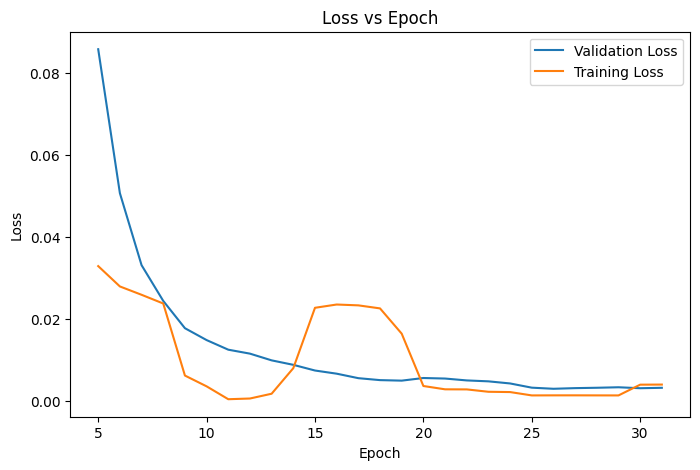

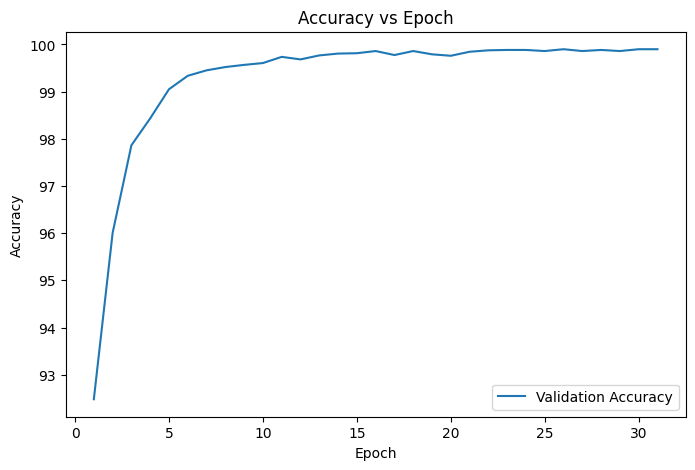

In [20]:
lossdf = pd.read_csv("mobilenetv3_large_loss.csv", engine="pyarrow")
rolling_mean = lossdf["val_loss"].rolling(window=5).mean()
rolling_mean2 = lossdf["train_loss"].rolling(window=5).mean()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], rolling_mean, label="Validation Loss")
plt.plot(lossdf["epoch"], rolling_mean2, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], lossdf["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.show()

Densenet

In [29]:
model = timm.create_model('densenet121', pretrained=True, num_classes=2, drop_rate=0.2).to(device)

losslogger = CSVLogger('densenet121_loss.csv', fieldnames=["datetime", "batch", "epoch", "train_loss", "val_loss", "val_accuracy"])
acclogger = CSVLogger('densenet121_acc.csv', fieldnames=["datetime", "average_accuracy"])
loss_value = torch.nn.CrossEntropyLoss()

model_opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Training loop
num_epochs = epochs  
early_stopping = False  
best_loss = float('inf') 

print(f"Device: {device}")

print(f"Start time: {datetime.datetime.now()}")


for epoch in range(num_epochs):
    model.train()  
    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        model_opt.zero_grad()
        outputs = model(inputs)
        loss = loss_value(outputs, labels)
        loss.backward()
        model_opt.step()
    
    # Validation
    model.eval()  
    total = 0
    correct = 0
    val_loss = 0.0
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss += loss_value(val_outputs, val_labels).item()
        _, predicted = torch.max(val_outputs.data, 1)
        total += val_labels.size(0)
        correct += (predicted == val_labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    losslog_data = {"datetime": datetime.datetime.now(), "batch": batch_size, "epoch": epoch+1, "train_loss": loss.item(), "val_loss": val_loss, "val_accuracy": val_accuracy}
    losslogger.log(losslog_data)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0  
    else:
        patience_counter += 1  
        
        # If validation loss hasn't improved for 'patience' epochs, stop early
        if patience_counter >= patience:
            print("Early stopping triggered")
            early_stopping = True
            break
    
    if early_stopping:
        break
    
    print(f"Completed epoch {epoch + 1} with loss {loss.item()}, validation loss {val_loss}")

# -----------------------------------------

correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
acclog_data = {"datetime": datetime.datetime.now(), "average_accuracy": accuracy}
acclogger.log(acclog_data)
print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# Save the model
torch.save(model.state_dict(), 'densenet121_large.pth')


Device: cuda
Start time: 2023-11-02 21:26:36.331384


KeyboardInterrupt: 

In [ ]:
lossdf = pd.read_csv("densenet121_loss.csv", engine="pyarrow")
rolling_mean = lossdf["val_loss"].rolling(window=5).mean()
rolling_mean2 = lossdf["train_loss"].rolling(window=5).mean()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], rolling_mean, label="Validation Loss")
plt.plot(lossdf["epoch"], rolling_mean2, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], lossdf["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.show()

InceptionV4

In [30]:
model = timm.create_model('inception_v4', pretrained=True, num_classes=2, drop_rate=0.2).to(device)

losslogger = CSVLogger('inception_v4_loss.csv', fieldnames=["datetime", "batch", "epoch", "train_loss", "val_loss", "val_accuracy"])
acclogger = CSVLogger('inception_v4_acc.csv', fieldnames=["datetime", "average_accuracy"])
loss_value = torch.nn.CrossEntropyLoss()

model_opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Training loop
num_epochs = epochs  
early_stopping = False  
best_loss = float('inf') 

print(f"Device: {device}")

print(f"Start time: {datetime.datetime.now()}")


for epoch in range(num_epochs):
    model.train()  
    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        model_opt.zero_grad()
        outputs = model(inputs)
        loss = loss_value(outputs, labels)
        loss.backward()
        model_opt.step()
    
    # Validation
    model.eval()  
    total = 0
    correct = 0
    val_loss = 0.0
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss += loss_value(val_outputs, val_labels).item()
        _, predicted = torch.max(val_outputs.data, 1)
        total += val_labels.size(0)
        correct += (predicted == val_labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    losslog_data = {"datetime": datetime.datetime.now(), "batch": batch_size, "epoch": epoch+1, "train_loss": loss.item(), "val_loss": val_loss, "val_accuracy": val_accuracy}
    losslogger.log(losslog_data)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0  
    else:
        patience_counter += 1  
        
        # If validation loss hasn't improved for 'patience' epochs, stop early
        if patience_counter >= patience:
            print("Early stopping triggered")
            early_stopping = True
            break
    
    if early_stopping:
        break
    
    print(f"Completed epoch {epoch + 1} with loss {loss.item()}, validation loss {val_loss}")

# -----------------------------------------

correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
acclog_data = {"datetime": datetime.datetime.now(), "average_accuracy": accuracy}
acclogger.log(acclog_data)
print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# Save the model
torch.save(model.state_dict(), 'inception_v4_large.pth')


Device: cuda
Start time: 2023-11-02 21:41:48.314433


KeyboardInterrupt: 

In [ ]:
lossdf = pd.read_csv("inception_v4_loss.csv", engine="pyarrow")
rolling_mean = lossdf["val_loss"].rolling(window=5).mean()
rolling_mean2 = lossdf["train_loss"].rolling(window=5).mean()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], rolling_mean, label="Validation Loss")
plt.plot(lossdf["epoch"], rolling_mean2, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], lossdf["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.show()

Vgg16

In [ ]:
model = timm.create_model('vgg16', pretrained=True, num_classes=2, drop_rate=0.2).to(device)

losslogger = CSVLogger('vgg16_loss.csv', fieldnames=["datetime", "batch", "epoch", "train_loss", "val_loss", "val_accuracy"])
acclogger = CSVLogger('vgg16_acc.csv', fieldnames=["datetime", "average_accuracy"])
loss_value = torch.nn.CrossEntropyLoss()

model_opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Training loop
num_epochs = epochs  
early_stopping = False  
best_loss = float('inf') 

print(f"Device: {device}")

print(f"Start time: {datetime.datetime.now()}")


for epoch in range(num_epochs):
    model.train()  
    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        model_opt.zero_grad()
        outputs = model(inputs)
        loss = loss_value(outputs, labels)
        loss.backward()
        model_opt.step()

    print("Training done")
    
    # Validation
    model.eval()  
    total = 0
    correct = 0
    val_loss = 0.0
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss += loss_value(val_outputs, val_labels).item()
        _, predicted = torch.max(val_outputs.data, 1)
        total += val_labels.size(0)
        correct += (predicted == val_labels).sum().item()

    print("Validation done")
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    losslog_data = {"datetime": datetime.datetime.now(), "batch": batch_size, "epoch": epoch+1, "train_loss": loss.item(), "val_loss": val_loss, "val_accuracy": val_accuracy}
    losslogger.log(losslog_data)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0  
    else:
        patience_counter += 1  
        
        # If validation loss hasn't improved for 'patience' epochs, stop early
        if patience_counter >= patience:
            print("Early stopping triggered")
            early_stopping = True
            break
    
    if early_stopping:
        break
    
    print(f"Completed epoch {epoch + 1} with loss {loss.item()}, validation loss {val_loss}")

# -----------------------------------------

correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
acclog_data = {"datetime": datetime.datetime.now(), "average_accuracy": accuracy}
acclogger.log(acclog_data)
print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# Save the model
torch.save(model.state_dict(), 'vgg16_large.pth')

# -----------------------------------------

Device: cuda
Start time: 2023-11-02 14:14:49.279462


KeyboardInterrupt: 

Inceptionv3
